In a previous notebook, we sought the ground state of many-body systems, and connected this problem to binary optimization computer science. As we have seen, this connection is useful to understand for adiabatic quantum computing and variational algorithms.

However, we also talked about the engineering constraints we face in real devices: the evolution in these devices is actually that of an open quantum system, where the quantum processing unit interacts with the environment.

<img src="figures/open_system.svg" alt="A quantum processor as an open quantum system" style="width: 400px;"/>

The environment has a defined temperature and if we let the system equilibrate, the QPU becomes thermalized and the energy of the states will follow a Boltzmann distribution.

When using quantum computers for optimization, we retain one sample out of the hundreds or thousands, and discard the rest. On the other hand, if we keep all of them and study their energy distribution, they actually approximate a Boltzmann distribution at some finite temperature: $P(E_i) = \frac {e^{-E_{i}/T}}{\sum _{j=1}^{M}{e^{-E_{j}/T}}}$. We can use this phenomenon for training certain machine learning models, as we will see later. In this notebook, we gain some more insight on preparing the thermal state by annealing and also by a variational circuit.

# Quantum annealing

Let us start by importing a handful of packages:

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import dimod
%matplotlib inline

We are interested in the thermal state of the classical Ising model. We create a random model over ten spins and we will sample a hundred states.

In [2]:
n_spins = 10
n_samples = 1000
h = {v: np.random.uniform(-2, 2) for v in range(n_spins)}
J = {}
for u, v in itertools.combinations(h, 2):
    if np.random.random() < .05:
        J[(u, v)] = np.random.uniform(-1, 1)
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()        

Let's sample the energies at different temperatures. The `dimod` implementation of simulated annealing allows us to set an initial and final temperature for the annealing. If we set it to the same value, we mimic the effect of a finite temperature and we will have a wider range of configurations and energy levels in the samples. The next cell can take a while to execute.

In [3]:
temperature_0 = 1
response = sampler.sample(model, beta_range=[1/temperature_0, 1/temperature_0], num_reads=n_samples)
energies_0 = [solution.energy for solution in response.data()]
temperature_1 = 10
response = sampler.sample(model, beta_range=[1/temperature_1, 1/temperature_1], num_reads=n_samples)
energies_1 = [solution.energy for solution in response.data()]
temperature_2 = 100
response = sampler.sample(model, beta_range=[1/temperature_2, 1/temperature_2], num_reads=n_samples)
energies_2 = [solution.energy for solution in response.data()]

We define a function to plot the resulting probability distribution.

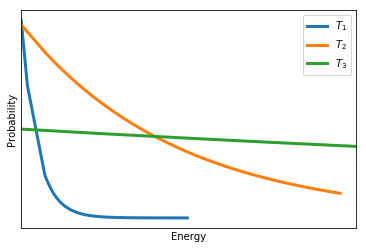

In [4]:
def plot_probabilities(energy_samples, temperatures):
    fig, ax = plt.subplots()
    for i, (energies, T) in enumerate(zip(energy_samples, temperatures)):
        probabilities = np.exp(-np.array(sorted(energies))/T)
        Z = probabilities.sum()
        probabilities /= Z
        ax.plot(energies, probabilities, linewidth=3, label = "$T_" + str(i+1)+"$")
    minimum_energy = min([min(energies) for energies in energy_samples])
    maximum_energy = max([max(energies) for energies in energy_samples])
    ax.set_xlim(minimum_energy, maximum_energy)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Energy')
    ax.set_ylabel('Probability')
    ax.legend()
    plt.show()

plot_probabilities([energies_0, energies_1, energies_2], 
                   [temperature_0, temperature_1, temperature_2])

Just as we saw in the notebook on evolution in open systems, the distribution flattens out at a high temperature ($T_3$). On the other hand, the energy is peaked for a low temperature, and we do not even have samples for high-energy states.

# Quantum Approximate Thermalization

There are many results for preparing a thermal state on a gate-model quantum computer, but most of them need a large-scale device. More recently, a protocol for approximating thermalization was developed using shallow circuits. The idea is that if we knew that the thermal state was a qubit $\psi$ (which means $\rho=|\psi \rangle \langle \psi |$), we could apply QAOA, starting from the ground state. The trick is to purify $\rho$ on a larger Hilbert space. If we call $\mathcal{H_1}$ our current Hilbert space, purifying a density matrix $\rho$ consists of finding a second Hilbert space $\mathcal{H_2}$ such that there exists $| \psi \rangle \in \mathcal{H_1} \otimes \mathcal{H_2}$ such that $\rho = \textrm{Tr}_{\mathcal{H_2}} \left( |\psi \rangle \langle \psi | \right)$, where $\textrm{Tr}_{\mathcal{H_2}}$ is the partial trace taken over the second Hilbert space -- in essence, we are marginalizing the probability distribution. It can be shown that $| \psi \rangle =\sqrt{2 \cosh \beta} \sum_{z \in {-1,1}} e^{-\beta z} |z \rangle_{\mathcal{H_1}} \otimes | z \rangle_{\mathcal{H_2}}$ purifies $\rho=e^{-\beta H_m}$ [[1](#1)]. This state can be built with a circuit composed uniquely of RX gates and CNOT gates

In [5]:
import itertools
import numpy as np
from functools import reduce
from qiskit import Aer, QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import execute
from qiskit.tools.qi.pauli import Pauli
from qiskit_aqua.operator import Operator
from qiskit_aqua import get_optimizer_instance
from qiskit_aqua.algorithms.adaptive.qaoa import QAOA
from qiskit_aqua.algorithms.adaptive.qaoa.varform import QAOAVarForm

We create an example system of two qubits that need two extra qubits for purification. We set $\beta=10$.

In [6]:
n_qubits = 2
n_system = n_qubits * 2
β = 10

We define a simple Ising model with a weight matrix and set $p=1$ in QAOA.

In [7]:
weights = np.array([[0,1],[0,0]])
p = 1

Based on these parameters, we define the Ising Hamiltonian:

In [8]:
def pauli_z(qubit, coeff):
    eye = np.eye((n_system))
    return Operator([[coeff, Pauli(eye[qubit], np.zeros(n_system))]])

def pauli_x(qubit, coeff):
    eye = np.eye((n_system))
    return Operator([[1, Pauli(np.zeros(n_system), eye[qubit])]])

def product_pauli_z(q1, q2, coeff):
    eye = np.eye((n_system))
    return Operator([[coeff, Pauli(eye[q1], np.zeros(n_system)) * Pauli(eye[q2], np.zeros(n_system))]])

def ising_hamiltonian(weights):
    H = reduce(lambda x,y:x+y,
            [product_pauli_z(i,j, -weights[i,j])
             for (i,j) in itertools.product(range(n_qubits), range(n_qubits))])
    H.to_matrix()
    return H

Hc = ising_hamiltonian(weights)

We prepare the intial state $|\psi_0 \rangle = \sqrt{2 cosh(\beta)} \sum_{z \in {1, -1}} e^{-\beta z} | z \rangle_S \otimes | z \rangle_E$, with $E$ a temporary space used for purification purpose. It can be shown that tracing out this state over $E$ reproduces the state $\rho \propto e^{-\beta H_m} $. We initialize the circuit first:

In [9]:
qr = QuantumRegister(n_qubits * 2)
cr = ClassicalRegister(n_qubits)
backend = Aer.get_backend('qasm_simulator')
circuit_init = QuantumCircuit(qr)

And we prepare the state:

In [10]:
α = 2 * np.arctan(np.exp(- β/2))
for i in range(n_qubits):
    circuit_init.rx(α, qr[n_qubits+i])
    circuit_init.cx(qr[n_qubits+i], qr[i])

The class `QAOAVarForm` takes an initial state as argument, which should be an object containing a method `construct_circuit` that builds and returns the initial state

In [11]:
class InitialState:
    def __init__(self, beta, n_qubits):
        self.beta = beta
        self.n_qubits = n_qubits
    
    def construct_circuit(self, mode, qr):
        circuit_init = QuantumCircuit(qr)

        alpha = 2 * np.arctan(np.exp(- self.beta / 2))
        for i in range(n_qubits):
            circuit_init.rx(alpha, qr[n_qubits+i])
            circuit_init.cx(qr[n_qubits+i], qr[i])
            
        return circuit_init

We need to overload the original QAOA class to be able pass it an initial state as a parameter

In [12]:
class MyQAOA(QAOA):
    def init_args(self, operator, operator_mode, p, optimizer, init_state=None, opt_init_point=None, aux_operators=[]):
        """
        Args:
            operator (Operator): Qubit operator
            operator_mode (str): operator mode, used for eval of operator
            p (int) : the integer parameter p as specified in https://arxiv.org/abs/1411.4028
            optimizer (Optimizer) : the classical optimization algorithm.
            opt_init_point (str) : optimizer initial point.
        """
        var_form = QAOAVarForm(operator, p, init_state)
        super(QAOA, self).init_args(operator, operator_mode, var_form, optimizer, opt_init_point=opt_init_point)
        
class MyQAOAVarForm(QAOAVarForm):
    def construct_circuit(self, angles, quantum_register, classical_register):
        if not len(angles) == self.num_parameters:
            raise ValueError('Incorrect number of angles: expecting {}, but {} given.'.format(
                self.num_parameters, len(angles)
            ))
        q = quantum_register
        circuit = QuantumCircuit(quantum_register, classical_register)
        if self._initial_state:
            circuit += self._initial_state.construct_circuit('circuit', q)
        else:
            circuit.u2(0, np.pi, q)
        for idx in range(self._p):
            beta, gamma = angles[idx], angles[idx + self._p]
            circuit += self._cost_operator.evolve(None, gamma, 'circuit', 1, quantum_registers=q)
            circuit += self._mixer_operator.evolve(None, beta, 'circuit', 1, quantum_registers=q)
        return circuit

We prepare the initial state:

In [13]:
initial_state = InitialState(β, n_qubits)

We run the protocol to get the thermal state:

In [14]:
def get_thermal_state(weights, p):
    Hc = ising_hamiltonian(weights)
    print("Begin QAOA...")
    
    qaoa = MyQAOA()
    qaoa.setup_quantum_backend(shots=100)
    optimizer = get_optimizer_instance('COBYLA')
    qaoa.init_args(Hc, "matrix", p, optimizer, initial_state)
    result = qaoa.run()
    
    print("Results of QAOA", result)
    
    return result

Finally, we reformat the final results, measure out the result, and plot the energy distribution:

Begin QAOA...
Results of QAOA {'eigvals': array([-0.99981838]), 'opt_params': array([-0.0001,  0.    ]), 'eigvecs': array([[ 9.99954502e-01-3.99981687e-04j,  7.13762222e-07+9.99951810e-05j,
         7.13762221e-07+9.99951810e-05j, -9.99903721e-09+1.38752446e-10j,
         7.13762222e-07+9.99951810e-05j, -2.70505541e-06-6.73764043e-03j,
        -9.99903721e-09+1.38752446e-10j,  6.73762223e-07-4.81029202e-09j,
         7.13762222e-07+9.99951810e-05j, -9.99903721e-09+1.38752446e-10j,
        -2.70505541e-06-6.73764043e-03j,  6.73762223e-07-4.81029202e-09j,
        -9.99903721e-09+1.38752446e-10j,  6.73762223e-07-4.81029202e-09j,
         6.73762223e-07-4.81029202e-09j, -4.53978641e-05+1.82938994e-08j]]), 'energy': -0.9998183767763202, 'eval_count': 27, 'eval_time': 22.86650848388672}


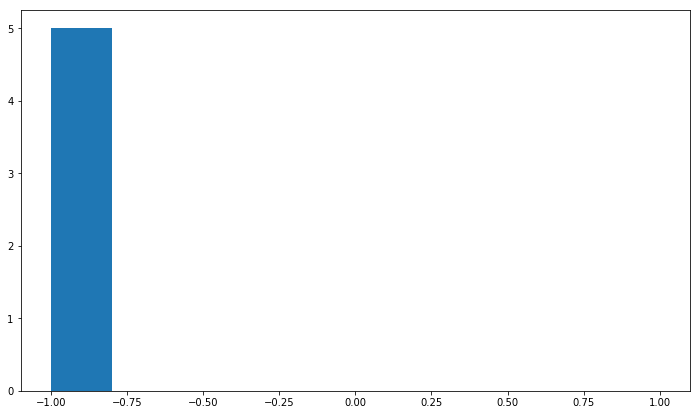

In [15]:
result = get_thermal_state(weights, 1)
var_form = MyQAOAVarForm(Hc, p, initial_state)
thermal_state = var_form.construct_circuit(result['opt_params'], qr, cr)
for i in range(n_qubits):
    thermal_state.measure(qr[i], cr[i])
    job = execute(thermal_state, backend, shots=2000)
results = job.result().get_counts(thermal_state)

def get_energy(spin_configuration):
    x = spin_configuration.reshape(-1, 1)
    return np.sum([[-weights[i,j] * x[i] * x[j] for j in range(n_qubits)] for i in range(n_qubits)])

list_spin_configs = np.array(np.concatenate([[list(spin_config)] * results[spin_config] for spin_config in results]), dtype="int")
list_spin_configs[list_spin_configs == 0] = -1
list_energy = np.array([get_energy(spin_config) for spin_config in list_spin_configs])
plt.rcParams['figure.figsize'] = (12,7)
hist = plt.hist(list_energy, density=True)

# References

[1] Verdon, G., Broughton, M., Biamonte, J. (2017) [A quantum algorithm to train neural networks using low-depth circuits](https://arxiv.org/abs/1712.05304). *arXiv:1712.05304*. <a id='1'></a>